In [1]:
import numpy as np
from string import ascii_lowercase
from copy import deepcopy
from math import prod
from dataclasses import dataclass, field
import pandas as pd
from functools import cached_property
import heapq
import matplotlib.pyplot as plt


ELEVATION_MAPPING = {letter: elevation for letter, elevation
                     in zip(ascii_lowercase, range(len(ascii_lowercase)))}
ELEVATION_MAPPING["S"] = 0
ELEVATION_MAPPING["E"] = 25

VECTOR_MAPPING = {"1,0": "V",
                  "-1,0": "^",
                  "0,-1": "<",
                  "0,1": ">"}


def pretty_print(input_array: np.ndarray) -> None:
    ''' Prints a matrix in a pretty way'''
    A = pd.DataFrame(input_array)
    A.columns = ['']*A.shape[1]
    print(A.to_string(index=False))


@dataclass
class Graph:
    '''A representation of the potential paths as a graph'''
    graph: dict = field(default_factory=dict[int, set[int]])
    graph_type: str = 'directed'

    def add_edge(self, source: int, destination: int):
        ''' Adds an edge to the graph structure'''
        if source not in self.graph.keys():
            self.graph[source] = set()
        self.graph[source].add(destination)

        # if the graph is not directed then it can go both ways
        if self.graph_type != 'directed':
            print('test')
            if destination not in self.graph:
                self.graph[destination] = set()
            self.graph[destination].add(source)

    def print_graph(self):
        '''Prints the graph structure'''
        for node, connections in self.graph.items():
            print(f"{node}-->{connections}")

    def shortest_path(self, start: int, stop: int) -> list[int]:
        '''Finds the shortest path between two points using Djikstra's algorithm'''
        # store the unvisited nodes
        unvisited = [(0, start)]

        # store the distance from the start node to each node
        distance = {start: 0}

        # store the previous node in the shortest path
        previous = {start: None}

        # while there are still unvisited nodes
        while unvisited:
            # get the node with the smallest distance
            current_distance, current_node = heapq.heappop(unvisited)

            # if we reached the end, build the path and return
            if current_node == stop:
                path = []
                while current_node is not None:
                    path.append(current_node)
                    current_node = previous[current_node]
                return path[::-1]

            # if we have already visited the current node, we skip it
            if current_distance > distance.get(current_node, float('inf')):
                continue

            # if the current node is a dead-end, we skip it
            if current_node not in self.graph.keys():
                continue

            for connection in self.graph[current_node]:
                new_distance = current_distance + 1
                # if the distance to the neighbor is shorter than the previous one
                if new_distance < distance.get(connection, float('inf')):
                    # update the distance and the previous node
                    distance[connection] = new_distance
                    previous[connection] = current_node
                    heapq.heappush(unvisited, (new_distance, connection))

        # if there is no path between the start and end nodes
        return None


@dataclass
class Map:
    '''A class to represent the topography'''
    txt_map: np.ndarray[str] = np.ndarray(shape=(0, 0))

    @property
    def shape(self) -> tuple[int, int]:
        '''The shape of the map'''
        return self.txt_map.shape

    @cached_property
    def node_map(self) -> np.ndarray:
        '''A map with the node id in each cell'''
        node_map = np.zeros(shape=self.shape, dtype=int)
        node_names = range(prod(self.shape))
        for i, name in enumerate(node_names):
            x, y = np.unravel_index(i, shape=self.shape)
            node_map[x, y] = name
        return node_map

    @cached_property
    def elevation_map(self) -> np.ndarray:
        '''A map with the elevation in each cell'''
        elevation_map = np.zeros(shape=self.shape, dtype=int)

        for letter, elevation in ELEVATION_MAPPING.items():
            elevation_map[self.txt_map == letter] = elevation

        return elevation_map

    @property
    def start_indicies(self) -> tuple[int, int]:
        '''The (row, col) of the starting point'''
        start_ind = np.where(self.txt_map == 'S')
        return (start_ind[0][0], start_ind[1][0])

    @property
    def stop_indicies(self) -> tuple[int, int]:
        '''The (row, col) of the stopping point'''
        stop_ind = np.where(self.txt_map == 'E')
        return (stop_ind[0][0], stop_ind[1][0])

    @property
    def stop(self) -> int:
        '''The node id of the stopping point'''
        return self.node_map[self.stop_indicies]

    @property
    def start(self) -> int:
        '''The node id of the starting point'''
        return self.node_map[self.start_indicies]

    def build_map_from_input(self, input_path: str):
        '''Take the path to the input file and created the txt map'''
        with open(input_path, 'r') as f:
            data = f.read().split('\n')

        map_list = [[i for i in line] for line in data]
        self.txt_map = np.array(map_list, dtype=object)

    def reachable(self, current_elevation: int, destination_elevation: int) -> bool:
        '''Checks to see if the destination node can be reached from the current node'''
        # Can go up only 1, but can go down any distance
        return (destination_elevation - current_elevation) <= 1

    @cached_property
    def graph(self) -> Graph:
        '''Creates the graph representation from the map'''
        graph = Graph()

        for row_ind, row in enumerate(self.elevation_map):
            for col_ind, current_elevation in enumerate(row):
                adjacent_nodes = []

                # evaluate the point north
                if row_ind != 0:
                    destination_index = (row_ind-1, col_ind)
                    adjacent_nodes.append((destination_index,
                                           self.elevation_map[destination_index]))
                # evaluate the point south
                if row_ind != self.shape[0]-1:
                    destination_index = (row_ind+1, col_ind)
                    adjacent_nodes.append((destination_index,
                                           self.elevation_map[destination_index]))
                # evaluate the point west
                if col_ind != 0:
                    destination_index = (row_ind, col_ind-1)
                    adjacent_nodes.append((destination_index,
                                           self.elevation_map[destination_index]))
                # evaluate the point east
                if col_ind != self.shape[1]-1:
                    destination_index = (row_ind, col_ind+1)
                    adjacent_nodes.append((destination_index,
                                           self.elevation_map[destination_index]))
                # check if the destinations are accessible and add them to graph
                for destination_index, destination_elevation in adjacent_nodes:
                    if self.reachable(current_elevation, destination_elevation):
                        graph.add_edge(self.node_map[row_ind, col_ind],
                                       self.node_map[destination_index])
        return graph

    def print_map(self):
        '''Prints the input map in a nice way'''
        pretty_print(self.txt_map)

    def get_indicies(self, node_id: int) -> tuple[int, int]:
        '''Return the index of a node id'''
        ind = np.where(self.node_map == node_id)
        return (ind[0][0], ind[1][0])

    def print_path(self, path: list[int]):
        '''Print the map with the provided path shown'''
        path_array = deepcopy(self.txt_map)
        path_array[:, :] = "."
        for i, val in enumerate(path[:-1]):
            row_ind, col_ind = np.unravel_index(val, shape=self.shape)
            next_row_ind, next_col_ind = np.unravel_index(path[i+1],
                                                          shape=self.shape)
            diff_list = ",".join([str(next_row_ind-row_ind),
                                  str(next_col_ind-col_ind)])
            vect_char = VECTOR_MAPPING[diff_list]
            path_array[row_ind, col_ind] = vect_char
        path_array[self.start_indicies] = "S"
        path_array[self.stop_indicies] = "E"
        pretty_print(path_array)

In [2]:
input_path = "input.txt"

# part 1
my_map = Map()
my_map.build_map_from_input(input_path)
shortest_path = my_map.graph.shortest_path(my_map.start, my_map.stop)
shortest_path_length = len(shortest_path)-1
print(f'The shortest path takes {shortest_path_length} steps')
# my_map.print_path(shortest_path)

The shortest path takes 528 steps


In [3]:
import networkx as nx

G = nx.DiGraph()
for node, connections in my_map.graph.graph.items():
    for connection in connections:
        G.add_edge(node, connection)

nx_shortest = nx.shortest_path(G, my_map.start, my_map.stop)
len(nx_shortest)-1

520

In [7]:
print(len(nx_shortest))
print(len(shortest_path))

521
529


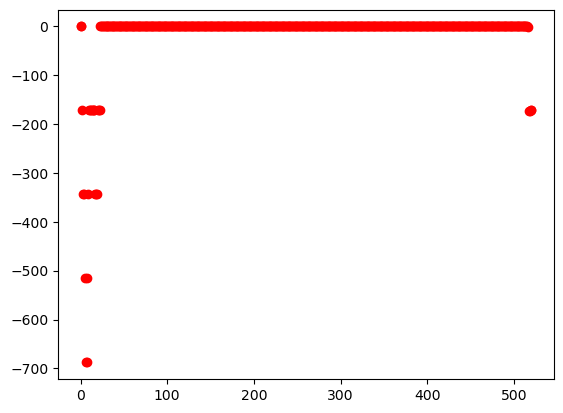

In [6]:
pos_diff = [x-y for x,y in zip(shortest_path, nx_shortest)]
plt.plot(pos_diff, 'or')
# plt.plot(nx_shortest, '*b')

In [9]:
import heapq

def shortest_path(graph, start, end):
    # Create a priority queue to store the unvisited nodes
    unvisited = [(0, start)]
    # Create a dictionary to store the distance from the start node to each node
    distance = {start: 0}
    # Create a dictionary to store the previous node in the shortest path
    previous = {start: None}
    # While there are unvisited nodes
    while unvisited:
        # Get the node with the smallest distance
        current_distance, current_node = heapq.heappop(unvisited)
        # If we have reached the end node, we can return the shortest path
        if current_node == end:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = previous[current_node]
            return path[::-1]
        # If we have already visited the current node, we skip it
        if current_distance > distance.get(current_node, float('inf')):
            continue
        # if the current node is a dead-end, we skip it
        if current_node not in graph.keys():
            continue
        # Otherwise, we visit the current node
        for neighbor in graph[current_node]:
            new_distance = current_distance + 1
            # If the new distance to the neighbor is shorter than the previous one
            if new_distance < distance.get(neighbor, float('inf')):
                # Update the distance and the previous node
                distance[neighbor] = new_distance
                previous[neighbor] = current_node
                heapq.heappush(unvisited, (new_distance, neighbor))
    # If there is no path between the start and end nodes
    return None


In [12]:
short_length = shortest_path(my_map.graph.graph, my_map.start, my_map.stop)
print(len(short_length)-1)

520
